<a href="https://colab.research.google.com/github/Momentum1ab/MomentumScreener/blob/main/Market_Breadth_Indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

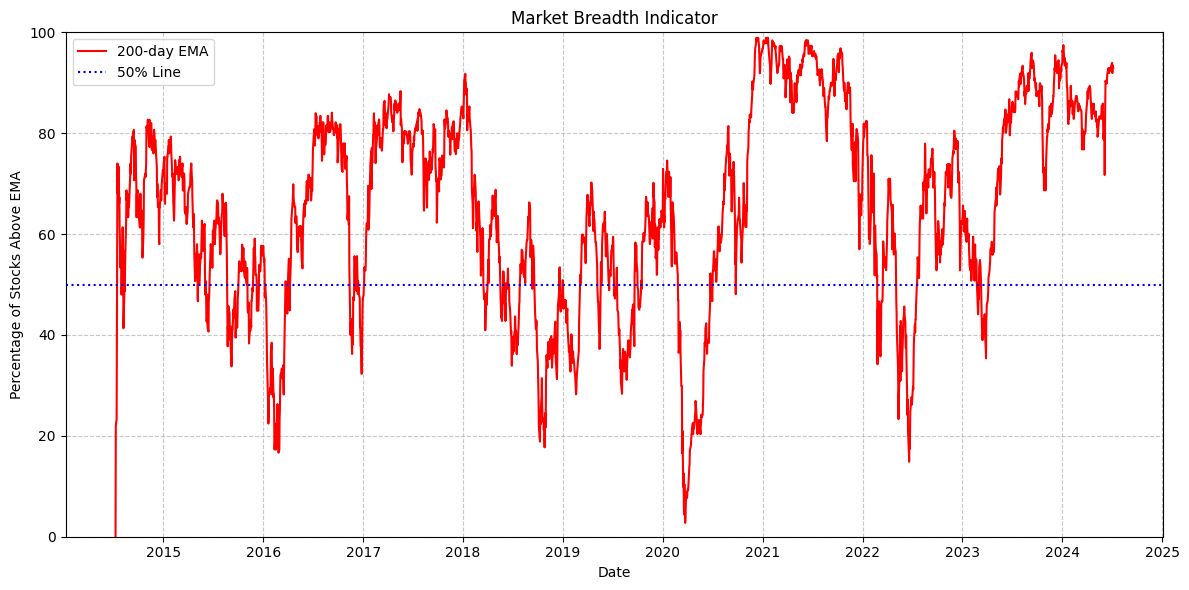

Latest percentage above 50-day EMA: 86.87%
Latest percentage above 200-day EMA: 92.93%


In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta

def get_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365*10)
        hist = stock.history(start=start_date, end=end_date)
        return hist['Close']
    except:
        return None

def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

def is_above_ema(ticker):
    data = get_stock_data(ticker)
    if data is None or len(data) < 200:
        return None

    ema_50 = calculate_ema(data, 50)
    ema_200 = calculate_ema(data, 200)

    above_50 = data > ema_50
    above_200 = data > ema_200

    return above_50, above_200

def calculate_market_breadth(tickers):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(is_above_ema, tickers))

    valid_results = [r for r in results if r is not None]

    df_50 = pd.concat([r[0] for r in valid_results], axis=1)
    df_200 = pd.concat([r[1] for r in valid_results], axis=1)

    percent_above_50 = df_50.mean(axis=1) * 100
    percent_above_200 = df_200.mean(axis=1) * 100

    return percent_above_50, percent_above_200

# Replace this with your list of 200 NSE tickers
nse_tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "BHARTIARTL.NS", "ICICIBANK.NS", "SBIN.NS", "INFY.NS",
           "LICI.NS", "HINDUNILVR.NS", "ITC.NS", "LT.NS", "BAJFINANCE.NS", "MARUTI.NS", "HCLTECH.NS",
           "ADANIENT.NS", "AXISBANK.NS", "SUNPHARMA.NS", "TATAMOTORS.NS", "TATAMTRDVR.NS", "M&M.NS",
           "NTPC.NS", "KOTAKBANK.NS", "ONGC.NS", "HAL.NS", "DMART.NS", "TITAN.NS", "ULTRACEMCO.NS",
           "ADANIPORTS.NS", "ADANIPOWER.NS", "ADANIGREEN.NS", "COALINDIA.NS", "POWERGRID.NS", "ASIANPAINT.NS",
           "BAJAJ-AUTO.NS", "WIPRO.NS", "BAJAJFINSV.NS", "SIEMENS.NS", "NESTLEIND.NS", "IOC.NS", "IRFC.NS",
           "JIOFIN.NS", "TATASTEEL.NS", "JSWSTEEL.NS", "DLF.NS", "BEL.NS", "VBL.NS", "TRENT.NS", "VEDL.NS",
           "ABB.NS", "INDIGO.NS", "ZOMATO.NS", "GRASIM.NS", "PFC.NS", "PIDILITIND.NS", "AMBUJACEM.NS",
           "HINDALCO.NS", "LTIM.NS", "GODREJCP.NS", "SBILIFE.NS", "LODHA.NS", "TATAPOWER.NS", "BANKBARODA.NS",
           "GAIL.NS", "PNB.NS", "TECHM.NS", "BRITANNIA.NS", "RECLTD.NS", "EICHERMOT.NS", "BPCL.NS",
           "HDFCLIFE.NS", "CIPLA.NS", "DIVISLAB.NS", "HAVELLS.NS", "INDUSINDBK.NS", "TVSMOTOR.NS",
           "ADANIENSOL.NS", "CHOLAFIN.NS", "UNIONBANK.NS", "HEROMOTOCO.NS", "JSWENERGY.NS", "DABUR.NS",
           "TATACONSUM.NS", "CANBK.NS", "ATGL.NS", "ZYDUSLIFE.NS", "MOTHERSON.NS", "IDEA.NS", "JINDALSTEL.NS",
           "NHPC.NS", "POLYCAB.NS", "CGPOWER.NS", "DRREDDY.NS", "CUMMINSIND.NS", "BHEL.NS", "TORNTPHARM.NS",
           "SHREECEM.NS", "SHRIRAMFIN.NS", "INDUSTOWER.NS", "BAJAJHLDNG.NS", "IDBI.NS", "BOSCHLTD.NS",
           "APOLLOHOSP.NS", "MANKIND.NS", "MARICO.NS", "INDHOTEL.NS", "ICICIPRULI.NS", "HDFCAMC.NS",
           "ICICIGI.NS", "COLPAL.NS", "NAUKRI.NS", "MAXHEALTH.NS", "GODREJPROP.NS", "IRCTC.NS", "RVNL.NS",
           "TIINDIA.NS", "NMDC.NS", "LUPIN.NS", "HINDPETRO.NS", "AUROPHARMA.NS", "BHARATFORG.NS",
           "SUPREMEIND.NS", "OFSS.NS", "YESBANK.NS", "INDIANB.NS", "TORNTPOWER.NS", "PRESTIGE.NS",
           "OBEROIRLTY.NS", "SRF.NS", "SBICARD.NS", "ASHOKLEY.NS", "SUZLON.NS", "OIL.NS", "CONCOR.NS",
           "MAZDOCK.NS", "SAIL.NS", "BALKRISIND.NS", "ABCAPITAL.NS", "DIXON.NS", "PERSISTENT.NS", "ALKEM.NS",
           "JSWINFRA.NS", "POLICYBZR.NS", "ASTRAL.NS", "BERGEPAINT.NS", "PIIND.NS", "BANKINDIA.NS",
           "IDFCFIRSTB.NS", "MRF.NS", "BDL.NS", "SJVN.NS", "GMRINFRA.NS", "TATACOMM.NS", "PATANJALI.NS",
           "LTTS.NS", "AUBANK.NS", "NYKAA.NS", "VOLTAS.NS", "MAHABANK.NS", "ACC.NS", "MPHASIS.NS", "FACT.NS",
           "PETRONET.NS", "APLAPOLLO.NS", "TATAELXSI.NS", "ESCORTS.NS", "TATATECH.NS", "PAGEIND.NS",
           "KALYANKJIL.NS", "LTF.NS", "KPITTECH.NS", "UPL.NS", "GUJGASLTD.NS", "BIOCON.NS", "FEDERALBNK.NS",
           "SONACOMS.NS", "LICHSGFIN.NS", "BSE.NS", "COFORGE.NS", "POONAWALLA.NS", "FORTIS.NS", "M&MFIN.NS",
           "JUBLFOOD.NS", "DALBHARAT.NS", "ABFRL.NS", "IGL.NS", "MFSL.NS", "BANDHANBNK.NS", "DEEPAKNTR.NS",
           "APOLLOTYRE.NS", "GLAND.NS", "IPCALAB.NS", "DELHIVERY.NS", "SUNTV.NS", "SYNGENE.NS", "TATACHEM.NS",
           "PAYTM.NS", "LAURUSLABS.NS", "LALPATHLAB.NS", "PEL.NS", "ZEEL.NS","UNITDSPR.NS"]  # Add all 200 tickers here

percent_above_50, percent_above_200 = calculate_market_breadth(nse_tickers)

# Plotting
plt.figure(figsize=(12, 6))
#plt.plot(percent_above_50.index, percent_above_50, color='green', label='50-day EMA')
plt.plot(percent_above_200.index, percent_above_200, color='red', label='200-day EMA')
plt.axhline(y=50, color='blue', linestyle=':', label='50% Line')

plt.title('Market Breadth Indicator')
plt.xlabel('Date')
plt.ylabel('Percentage of Stocks Above EMA')
plt.legend()
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print the latest values
print(f"Latest percentage above 50-day EMA: {percent_above_50.iloc[-1]:.2f}%")
print(f"Latest percentage above 200-day EMA: {percent_above_200.iloc[-1]:.2f}%")